In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 50
CSV_FILE_PATH = 'gyroscope_data.csv'

def alineData(df):
    def alineDateWithLabel(label, df):
        lable_data = df[df['activity_type'] == label]
        return lable_data[0:lable_data.shape[0] - lable_data.shape[0] % MEASUREMENTS_PER_SAMPLE]
    
    return pd.concat([alineDateWithLabel(label, df) for label in df['activity_type'].unique()])

df = alineData(pd.read_csv(CSV_FILE_PATH))
samples_number = df.shape[0] // MEASUREMENTS_PER_SAMPLE

def prepareTargets(df):
    df = df[df.columns[-1:len(df.columns)]]
    
    def prepareTarget(sample_index):
        sample_start_index = sample_index * MEASUREMENTS_PER_SAMPLE
        sample_end_index = (sample_index + 1) * MEASUREMENTS_PER_SAMPLE
        
        targets = df[sample_start_index:sample_end_index]['activity_type'].unique()
        
        if(targets.size > 1):
            raise ValueError('Sample can not have more then one target')
        
        return targets[0] 
    
    return LabelBinarizer().fit_transform(np.array([prepareTarget(index) for index in range(0, samples_number)]))

def prepareSamples(df):
    return df[df.columns[0:-1]].values.reshape((samples_number, MEASUREMENTS_PER_SAMPLE, 6))

samples = prepareSamples(df)
targets = prepareTargets(df)

print(samples.shape)
print(targets.shape)

(1260, 50, 6)
(1260, 3)


In [3]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = shuffleSamplesAndTargets(samples, targets)

In [4]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(756, 50, 6)
(756, 3)
(252, 50, 6)
(252, 3)
(252, 50, 6)
(252, 3)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.45))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [6]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='mse',
              metrics=['accuracy'])

In [7]:
history = model.fit(train_data,
                    train_labels,
                    epochs=350,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 756 samples, validate on 252 samples
Epoch 1/350
756/756 [==============================] - 0s 377us/step - loss: 0.3899 - acc: 0.3862 - val_loss: 0.3913 - val_acc: 0.3889
Epoch 2/350
756/756 [==============================] - 0s 91us/step - loss: 0.3581 - acc: 0.4339 - val_loss: 0.2646 - val_acc: 0.5754
Epoch 3/350
756/756 [==============================] - 0s 97us/step - loss: 0.3077 - acc: 0.5093 - val_loss: 0.2579 - val_acc: 0.5833
Epoch 4/350
756/756 [==============================] - 0s 96us/step - loss: 0.2763 - acc: 0.5688 - val_loss: 0.2768 - val_acc: 0.5675
Epoch 5/350
756/756 [==============================] - 0s 94us/step - loss: 0.2716 - acc: 0.5661 - val_loss: 0.2159 - val_acc: 0.6667
Epoch 6/350
756/756 [==============================] - 0s 96us/step - loss: 0.2524 - acc: 0.6085 - val_loss: 0.2240 - val_acc: 0.6548
Epoch 7/350
756/756 [==============================] - 0s 102us/step - loss: 0.2505 - acc: 0.6071 - val_loss: 0.2438 - val_acc: 0.6270
Epoch 8/350
75

756/756 [==============================] - 0s 88us/step - loss: 0.1307 - acc: 0.7751 - val_loss: 0.0875 - val_acc: 0.8373
Epoch 62/350
756/756 [==============================] - 0s 96us/step - loss: 0.1344 - acc: 0.7685 - val_loss: 0.0978 - val_acc: 0.8294
Epoch 63/350
756/756 [==============================] - 0s 93us/step - loss: 0.1375 - acc: 0.7646 - val_loss: 0.1175 - val_acc: 0.8056
Epoch 64/350
756/756 [==============================] - 0s 83us/step - loss: 0.1251 - acc: 0.7870 - val_loss: 0.0838 - val_acc: 0.8571
Epoch 65/350
756/756 [==============================] - 0s 95us/step - loss: 0.1141 - acc: 0.8029 - val_loss: 0.0987 - val_acc: 0.8294
Epoch 66/350
756/756 [==============================] - 0s 94us/step - loss: 0.1114 - acc: 0.7989 - val_loss: 0.1220 - val_acc: 0.8016
Epoch 67/350
756/756 [==============================] - 0s 80us/step - loss: 0.1247 - acc: 0.7738 - val_loss: 0.0898 - val_acc: 0.8413
Epoch 68/350
756/756 [==============================] - 0s 81us/step

756/756 [==============================] - 0s 87us/step - loss: 0.0575 - acc: 0.8929 - val_loss: 0.0585 - val_acc: 0.9008
Epoch 122/350
756/756 [==============================] - 0s 85us/step - loss: 0.0426 - acc: 0.9259 - val_loss: 0.0534 - val_acc: 0.9087
Epoch 123/350
756/756 [==============================] - 0s 82us/step - loss: 0.0524 - acc: 0.9034 - val_loss: 0.0542 - val_acc: 0.9008
Epoch 124/350
756/756 [==============================] - 0s 83us/step - loss: 0.0423 - acc: 0.9299 - val_loss: 0.0522 - val_acc: 0.8968
Epoch 125/350
756/756 [==============================] - 0s 81us/step - loss: 0.0548 - acc: 0.8955 - val_loss: 0.0621 - val_acc: 0.8810
Epoch 126/350
756/756 [==============================] - 0s 84us/step - loss: 0.0539 - acc: 0.8902 - val_loss: 0.0487 - val_acc: 0.9127
Epoch 127/350
756/756 [==============================] - 0s 85us/step - loss: 0.0458 - acc: 0.9193 - val_loss: 0.0441 - val_acc: 0.9286
Epoch 128/350
756/756 [==============================] - 0s 83

756/756 [==============================] - 0s 100us/step - loss: 0.0305 - acc: 0.9458 - val_loss: 0.0242 - val_acc: 0.9643
Epoch 182/350
756/756 [==============================] - 0s 102us/step - loss: 0.0296 - acc: 0.9484 - val_loss: 0.0285 - val_acc: 0.9484
Epoch 183/350
756/756 [==============================] - 0s 100us/step - loss: 0.0310 - acc: 0.9458 - val_loss: 0.0324 - val_acc: 0.9405
Epoch 184/350
756/756 [==============================] - 0s 100us/step - loss: 0.0230 - acc: 0.9563 - val_loss: 0.0380 - val_acc: 0.9286
Epoch 185/350
756/756 [==============================] - 0s 108us/step - loss: 0.0259 - acc: 0.9550 - val_loss: 0.0439 - val_acc: 0.9246
Epoch 186/350
756/756 [==============================] - 0s 113us/step - loss: 0.0267 - acc: 0.9563 - val_loss: 0.0416 - val_acc: 0.9206
Epoch 187/350
756/756 [==============================] - 0s 102us/step - loss: 0.0306 - acc: 0.9497 - val_loss: 0.0288 - val_acc: 0.9484
Epoch 188/350
756/756 [==============================] 

756/756 [==============================] - 0s 103us/step - loss: 0.0225 - acc: 0.9563 - val_loss: 0.0244 - val_acc: 0.9524
Epoch 242/350
756/756 [==============================] - 0s 96us/step - loss: 0.0167 - acc: 0.9722 - val_loss: 0.0243 - val_acc: 0.9563
Epoch 243/350
756/756 [==============================] - 0s 99us/step - loss: 0.0153 - acc: 0.9749 - val_loss: 0.0297 - val_acc: 0.9405
Epoch 244/350
756/756 [==============================] - 0s 95us/step - loss: 0.0161 - acc: 0.9709 - val_loss: 0.0429 - val_acc: 0.9246
Epoch 245/350
756/756 [==============================] - 0s 114us/step - loss: 0.0182 - acc: 0.9683 - val_loss: 0.0224 - val_acc: 0.9563
Epoch 246/350
756/756 [==============================] - 0s 110us/step - loss: 0.0144 - acc: 0.9775 - val_loss: 0.0249 - val_acc: 0.9603
Epoch 247/350
756/756 [==============================] - 0s 122us/step - loss: 0.0191 - acc: 0.9683 - val_loss: 0.0303 - val_acc: 0.9405
Epoch 248/350
756/756 [==============================] - 0

756/756 [==============================] - 0s 94us/step - loss: 0.0129 - acc: 0.9762 - val_loss: 0.0267 - val_acc: 0.9524
Epoch 302/350
756/756 [==============================] - 0s 100us/step - loss: 0.0149 - acc: 0.9762 - val_loss: 0.0231 - val_acc: 0.9603
Epoch 303/350
756/756 [==============================] - 0s 97us/step - loss: 0.0138 - acc: 0.9735 - val_loss: 0.0385 - val_acc: 0.9246
Epoch 304/350
756/756 [==============================] - 0s 83us/step - loss: 0.0124 - acc: 0.9775 - val_loss: 0.0214 - val_acc: 0.9683
Epoch 305/350
756/756 [==============================] - 0s 92us/step - loss: 0.0147 - acc: 0.9722 - val_loss: 0.0234 - val_acc: 0.9563
Epoch 306/350
756/756 [==============================] - 0s 99us/step - loss: 0.0096 - acc: 0.9815 - val_loss: 0.0227 - val_acc: 0.9603
Epoch 307/350
756/756 [==============================] - 0s 98us/step - loss: 0.0147 - acc: 0.9749 - val_loss: 0.0221 - val_acc: 0.9643
Epoch 308/350
756/756 [==============================] - 0s 1

              acc     val_acc        loss    val_loss
count  350.000000  350.000000  350.000000  350.000000
mean     0.895465    0.888367    0.062427    0.065845
std      0.108338    0.094837    0.068605    0.061270
min      0.386243    0.388889    0.006925    0.008494
25%      0.852183    0.869048    0.016352    0.028404
50%      0.947751    0.928571    0.029545    0.038603
75%      0.969577    0.948413    0.081025    0.072330
max      0.989418    0.984127    0.389909    0.391345


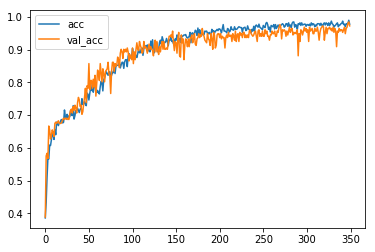

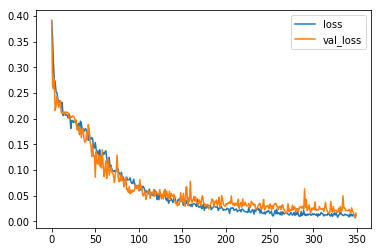

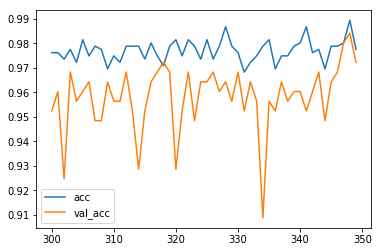

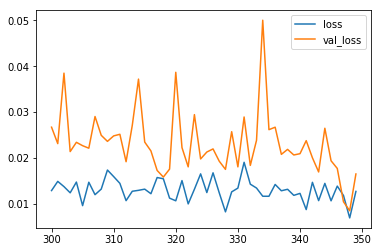

In [9]:
%matplotlib inline

history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs accuracy')

In [9]:
model.evaluate(test_data, test_labels)

252/252 [==============================] - 0s 39us/step


[0.02847646642106748, 0.9484127003049093]

In [10]:
model.predict(test_data[0:1])

array([[5.4339308e-27, 1.0000000e+00, 3.5008007e-28]], dtype=float32)